In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [35]:
len(words)

32033

In [36]:
# build a vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [37]:
# Compiling a dataset for the characters

block_size = 3 # context length; how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] #crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [38]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [39]:
C = torch.randn((27,2)) # Lookup table

In [40]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # Columns corresponding to the 5th row

tensor([-0.3185, -0.0268])

In [41]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [42]:
W1 = torch.randn((6, 100)) # Number of input layers (3 dimensional embedding and 2 of them (emb.shape))
                            # Number of neuron (upto us) is 100
b1 = torch.randn(100)

Now to implement the forward pass that is `emb @ W1 + b1` we will have to contactenate the emb such that the shape matches

In [43]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

Or we can use .view function of pytorch to view the same tensor in a different shape (more efficient). We can implement the forward pass. As concatenation creates more memory and makes the code inefficient

In [44]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Due to -1 pytorch derrives that shape

In [45]:
h.shape

torch.Size([228146, 100])

In [46]:
# The final layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [47]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim = True)
prob.shape

torch.Size([228146, 27])

In [67]:
# Fetches the probability of all the outputs and then selects the one from the labels
prob[torch.arange(32), Y[32]] 

tensor([2.8549e-03, 7.6338e-03, 5.7357e-06, 1.8777e-11, 1.4208e-02, 2.8549e-03,
        1.5442e-01, 9.6892e-01, 2.3052e-09, 3.6142e-03, 2.1673e-05, 3.8035e-04,
        2.8549e-03, 2.2447e-02, 4.1255e-03, 5.2676e-03, 2.8549e-03, 1.2339e-07,
        2.5208e-02, 8.6703e-03, 1.5222e-03, 8.4513e-10, 9.4212e-01, 6.0562e-02,
        2.4432e-05, 2.8549e-03, 7.9797e-02, 6.8568e-02, 4.3237e-07, 2.7650e-06,
        5.3619e-03, 2.0386e-03])

In [68]:
# Generating the loss
loss = -prob[torch.arange(32), Y[32]].log().mean()
loss

tensor(7.6572)

Let's sum up what we did above

In [82]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [83]:
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [84]:
for p in parameters:
    p.requires_grad=True

In [85]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [86]:
K = 1000
lri, lossi = [], []
for k in range(K):
    
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 6)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # this is better implementation
    if k % (K/10) == 0:
        print(f'The loss over iteration {k} is {loss.item()}') 
    # # the following code implements cross_entropy 
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim = True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[k]
    for p in parameters:
        p.data += -lr * p.grad
        # p.data += -0.01 * p.grad
    
    # track stats
    lri.append(lre[k])
    lossi.append(loss.item())


The loss over iteration 0 is 19.22757339477539
The loss over iteration 100 is 15.869296073913574
The loss over iteration 200 is 12.50022029876709
The loss over iteration 300 is 12.152055740356445
The loss over iteration 400 is 8.588068008422852
The loss over iteration 500 is 5.468189716339111
The loss over iteration 600 is 3.4511146545410156
The loss over iteration 700 is 3.156432628631592
The loss over iteration 800 is 3.159515857696533
The loss over iteration 900 is 5.168490886688232


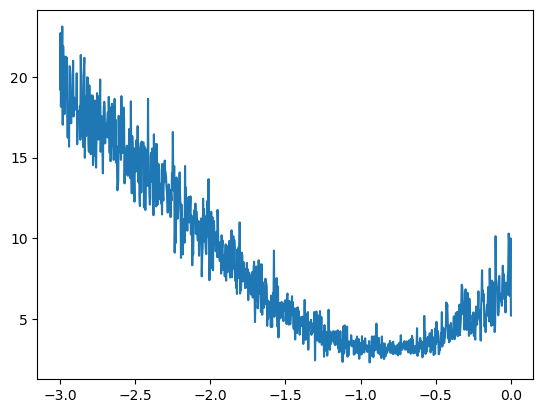

In [87]:
plt.plot(lri, lossi)

We can see that a good learning rate will be 0.1 from here.

It is much better to have an approximate gradient and take multiple steps then taking the actual gradient and taking less steps. (Efficiency wise)

In [88]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

8.424858093261719

Splitting the dataset in train val and test (80, 10, 10)

In [57]:
# Building the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'Shape of X and Y are {X.shape}, {Y.shape} respectively')
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Shape of X and Y are torch.Size([182625, 3]), torch.Size([182625]) respectively
Shape of X and Y are torch.Size([22655, 3]), torch.Size([22655]) respectively
Shape of X and Y are torch.Size([22866, 3]), torch.Size([22866]) respectively


In [58]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [59]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [60]:
sum(p.nelement() for p in parameters) # Number of parameters in total

for p in parameters:
    p.requires_grad=True

In [61]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
lri, lossi, stepi = [], [], []

In [62]:
K = 50000

for k in range(K):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 6)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # this is better implementation
    if k % (K/10) == 0:
        print(f'The loss over iteration {k} is {loss.item()}') 
    # # the following code implements cross_entropy 
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim = True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[k]
    for p in parameters:
        # p.data += -lr * p.grad
        p.data += -0.01 * p.grad
    
    # track stats
    # lri.append(lre[k])
    lossi.append(loss.log10().item())
    stepi.append(k)

The loss over iteration 0 is 27.107498168945312
The loss over iteration 5000 is 3.7257115840911865
The loss over iteration 10000 is 2.808560848236084
The loss over iteration 15000 is 3.2294397354125977
The loss over iteration 20000 is 2.768598794937134
The loss over iteration 25000 is 2.2934718132019043
The loss over iteration 30000 is 2.3009181022644043
The loss over iteration 35000 is 2.1471729278564453
The loss over iteration 40000 is 2.2586240768432617
The loss over iteration 45000 is 2.6995832920074463


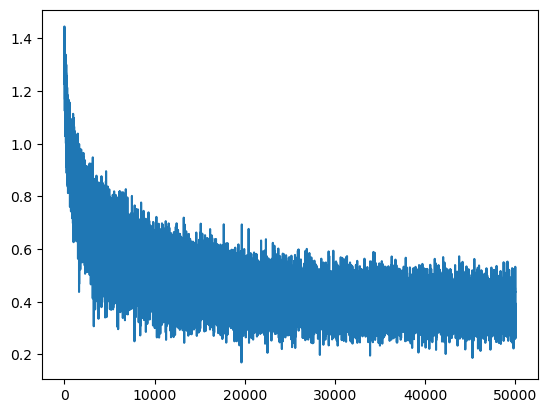

In [63]:
plt.plot(stepi, lossi)

The thickness at platue is due to the batch size being very small

In [64]:
# Evaluate
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.423079252243042

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

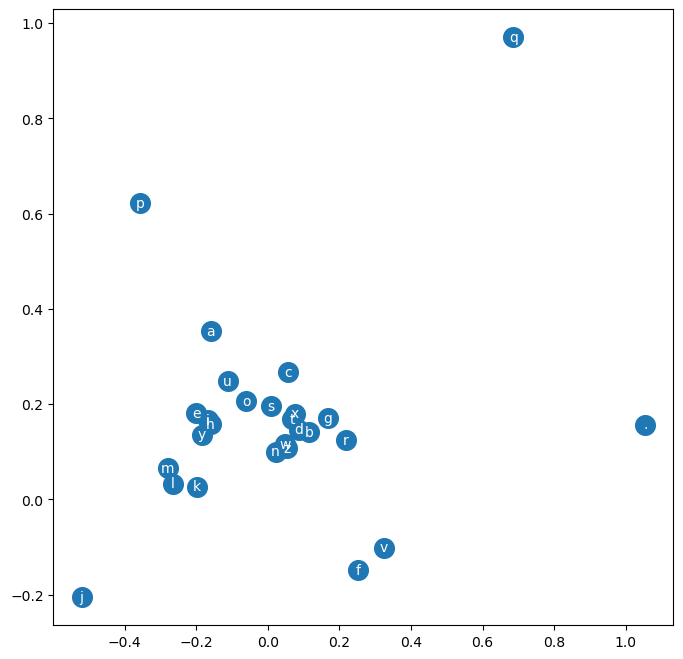

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va = "center", color = 'white')
plt.grid

In [66]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

aleidah.
roguce.
avaena.
elbyn.
karans.
tuheda.
safa.
geah.
adori.
jessa.
alabylyn.
ciil.
jesovyeah.
gorson.
kari.
iorg.
eva.
lawe.
auhethi.
achom.
